## Vector Autoregression

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(3)

In [25]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [26]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [27]:
df_elec_data = pd.concat([loaded_elec_data["df_elec_train"], loaded_elec_data["df_elec_validate"], loaded_elec_data["df_elec_test"]])
df_elec_data = df_elec_data.resample("MS").mean()

df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec_data)
df_elec_test.shape

(20, 4)

### Sanity Check

In [28]:
assert loaded_heat_data["df_heat_train"].shape == (49056, 6)
assert loaded_heat_data["df_heat_test"].shape == (14017, 6)
assert loaded_heat_data["df_heat_validate"].shape == (7007, 6)

assert loaded_elec_data["df_elec_train"].shape == (49056, 4)
assert loaded_elec_data["df_elec_test"].shape == (14017, 4)
assert loaded_elec_data["df_elec_validate"].shape == (7007, 4)

In [29]:
def display_time_series(df_train, df_validate, df_test, col="", figsize=(15,5), title="", ):
    ax = df_train[col].plot(figsize=figsize, color="tab:blue", label="Train")
    _ = df_test[col].plot(ax=ax, color="tab:red", label="Test")
    _ = df_validate[col].plot(ax=ax, color="tab:orange", label="Validate")
    
    ax.legend()
    ax.axvline(df_validate.index[0], linestyle=":")
    ax.axvline(df_test.index[0], linestyle=":")
    
    plt.title(title)
    plt.show()

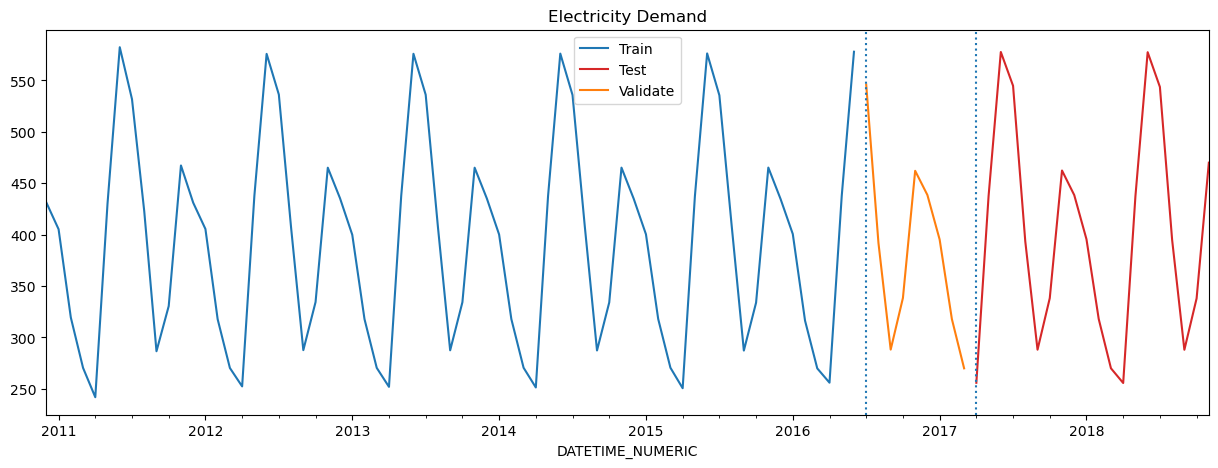

In [30]:
# display_time_series(df_heat_train, df_heat_validate, df_heat_test, col="heat_demand_values[kw]", title="Heat Demand")
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")

## Predicting Electricity Demand

In [31]:
print(f"Train Period: {df_elec_train.index.min()} ===> {df_elec_train.index.max()} shape: {df_elec_train.shape}")
print(f"Validation Period: {df_elec_validate.index.min()} ===> {df_elec_validate.index.max()} shape: {df_elec_validate.shape}")
print(f"Test Period: {df_elec_test.index.min()} ===> {df_elec_test.index.max()} shape: {df_elec_test.shape}")


Train Period: 2010-12-01 00:00:00 ===> 2016-06-01 00:00:00 shape: (67, 4)
Validation Period: 2016-07-01 00:00:00 ===> 2017-03-01 00:00:00 shape: (9, 4)
Test Period: 2017-04-01 00:00:00 ===> 2018-11-01 00:00:00 shape: (20, 4)


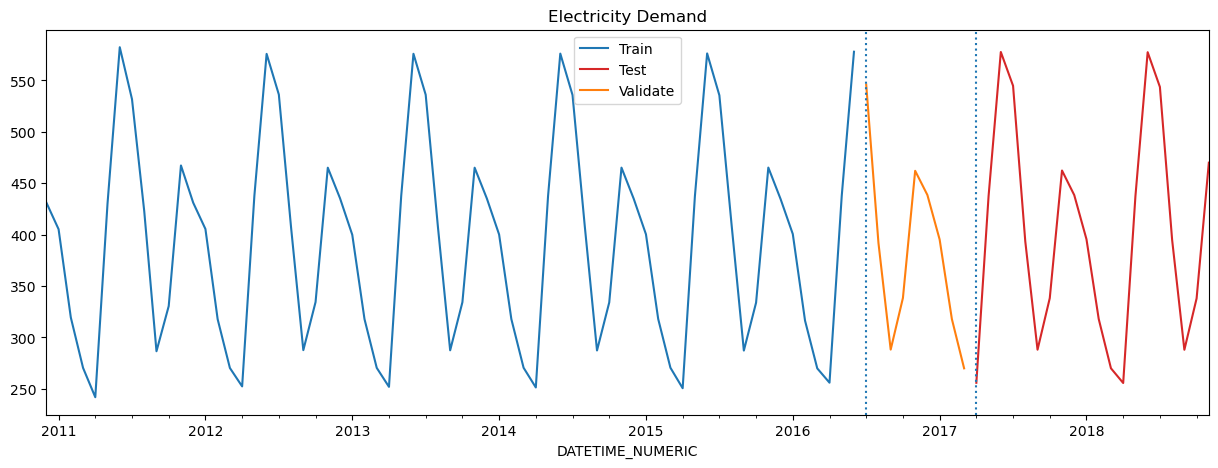

In [32]:
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")


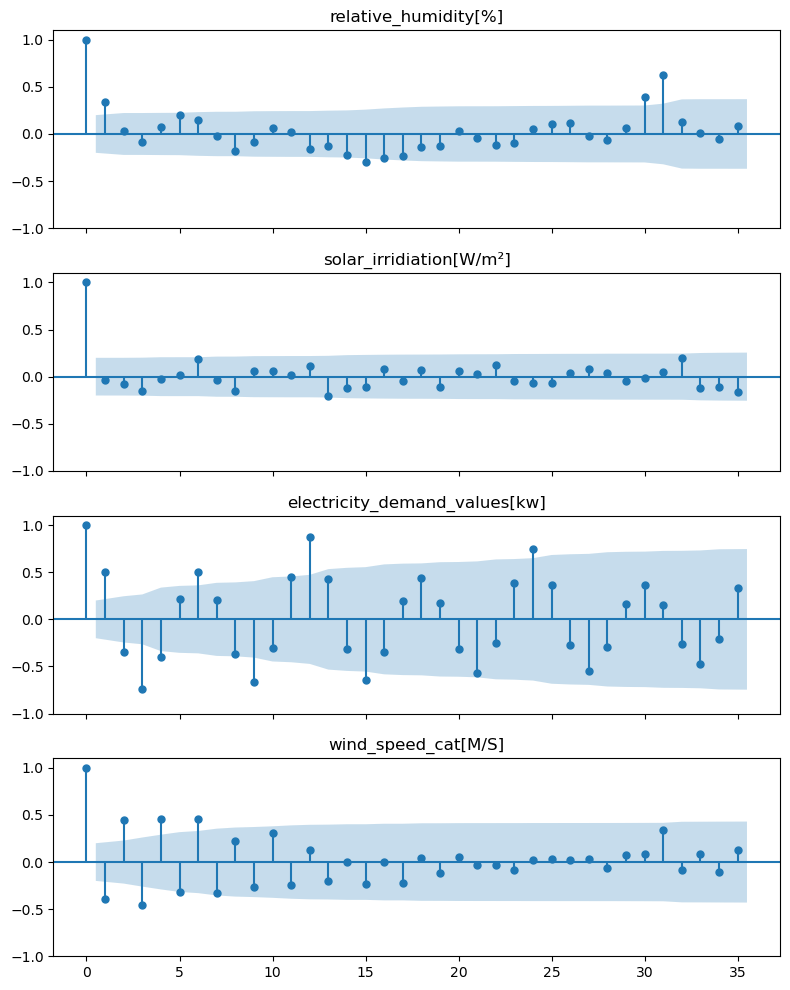

In [33]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)
axes = axes.flat
for i, col in enumerate(df_elec_data.columns):
    plot_acf(df_elec_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

In [34]:
from sklearn.ensemble import  HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries


In [35]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-01,68.212366,262.907258,431.253572,5.166667
2011-01-01,65.080645,256.361559,405.285442,4.768817
2011-02-01,70.523810,256.892857,319.422673,5.141369
2011-03-01,68.936828,259.619624,270.407960,4.638441
2011-04-01,56.777778,256.554167,241.873205,5.436111


In [36]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoregMultiSeries(
    regressor         = HistGradientBoostingRegressor(random_state=42),
    lags              = 27,
    transformer_series= StandardScaler()
)

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_elec_data,
                                       levels             = items,
                                       steps              = 6,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True                                   )

  0%|          | 0/4 [00:00<?, ?it/s]

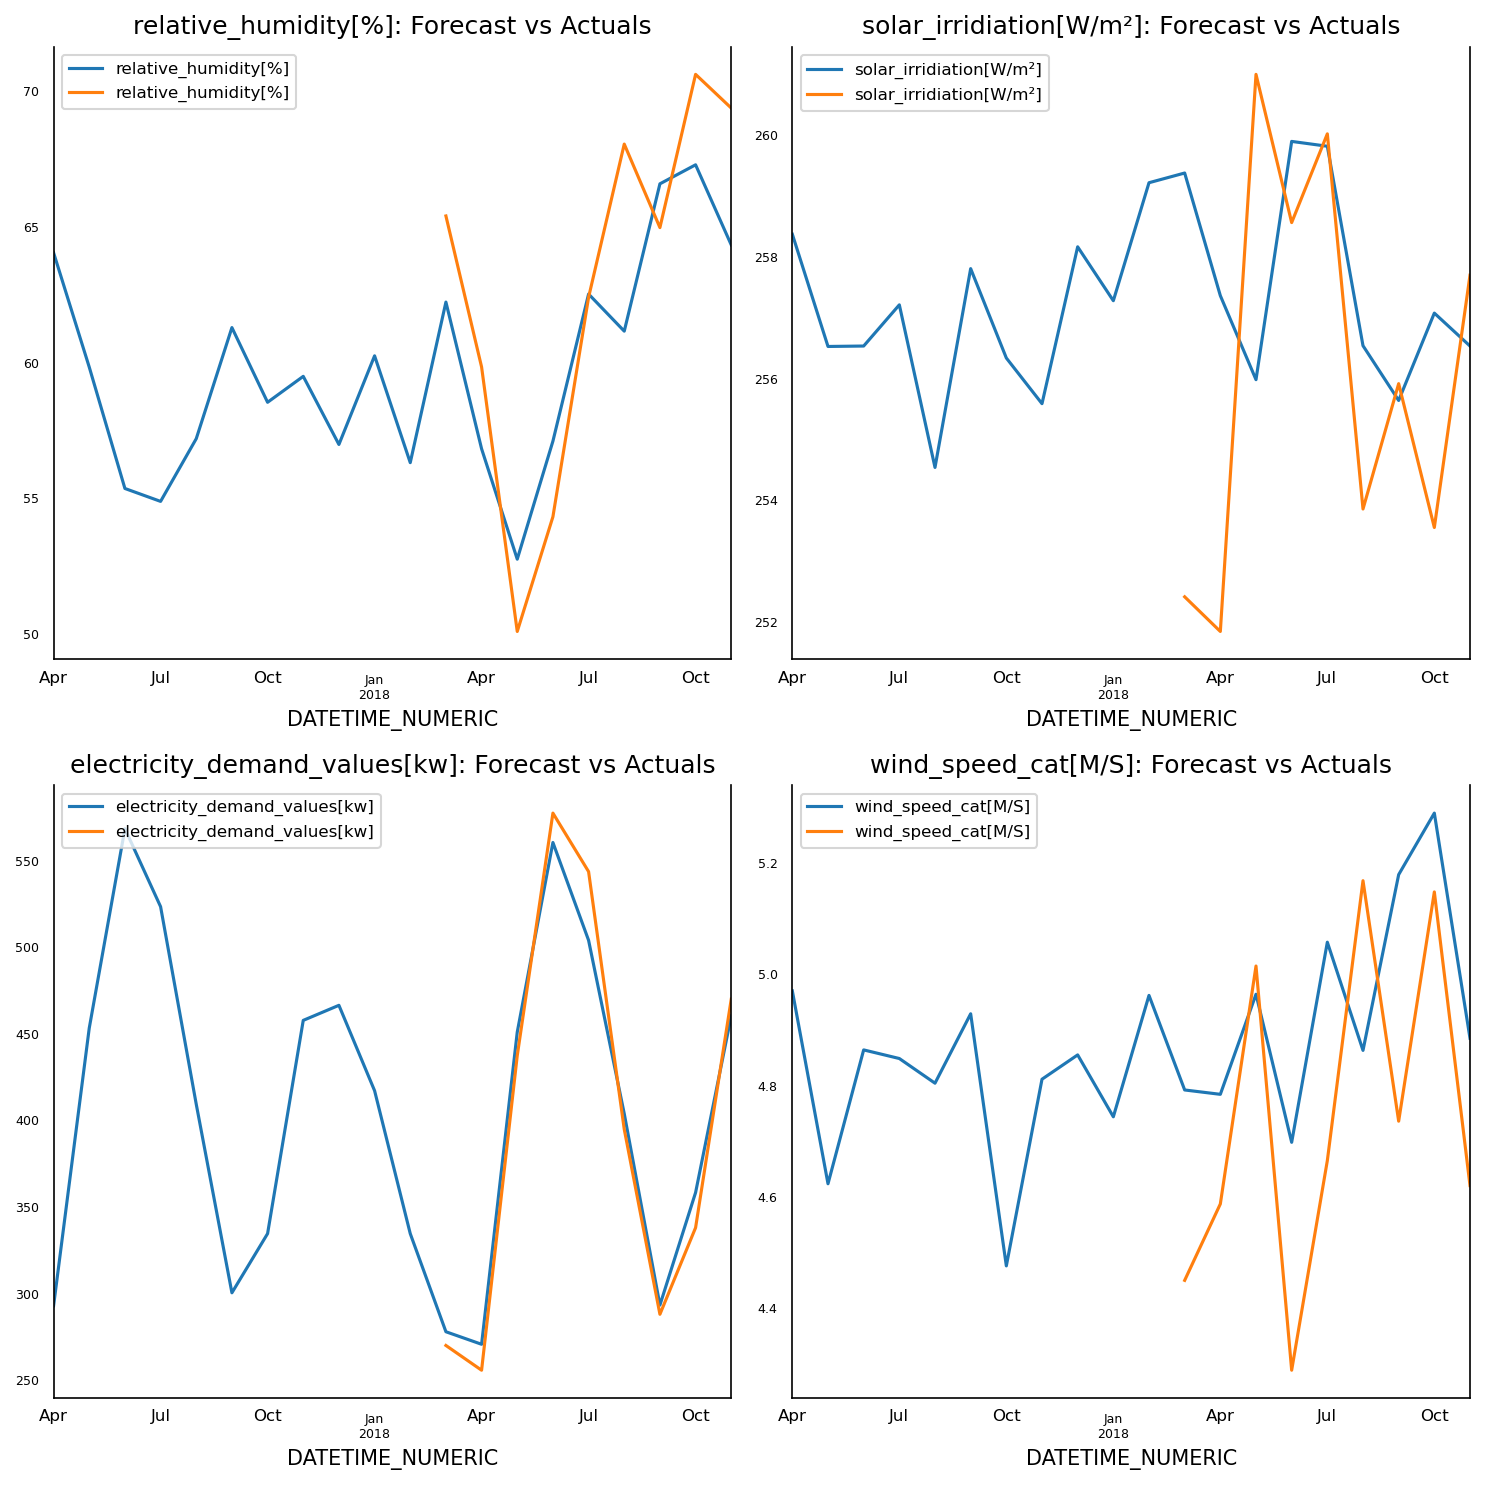

In [37]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(df_elec_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(df_elec_data.columns, axes.flatten())):
    predictions_ms[col].plot(legend=True, ax=ax, ).autoscale(axis='x',tight=True)
    df_elec_test[col][-len(df_elec_validate):].plot(legend=True, ax=ax, fontsize=8)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();